In [1]:
%matplotlib inline

from metapool.metapool import *

/Users/jonsanders/Development/anaconda/envs/py3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Knight Lab shotgun pipeline notebook

### What is it?

This Jupyter Notebook allows you to automatically produce most of the files you need for completing the Knight Lab shotgun sequencing pipeline.

Hopefully, this will not only make it much easier to generate these files, but also keep our information more accurate.

### Here's how it should work.

You'll start out with a **basic plate map**, which just links each sample to it's approprite row and column.

Then you'll add the output of the MiniPico assay of sample DNA concentrations, which will enable to you to automatically make a **normalization pick list** for starting the shotgun library prep itself. You can also visualize these concentrations on the plate, allowing you to double check the plate map and DNA concentration read.

Next you'll automatically assign barcodes to each sample, producing an **index pick list** for barcode addition prior to PCR.

After finishing the shotgun library prep itself, you'll measure library concentration with qPCR. This qPCR data file will then be read in and used to estimate and visualize pooling parameters, producing a **pooling pick list**. 

Finally, the per-sample information from the whole run can be combined to automatically produce a **sample sheet** that you can give directly to IGM for sequencing. 

# Workflow for normalizing DNA

This portion of the notebook will read in the output of the mini-Pico quantification assay and construct an Echo normalization picklist file. 

As inputs, it requires:
1. A tab-delimited row-wise plate map that indicates the sample name, well location, and blank status of each sample on the 384 well plate. 

The workflow then:
1. reads in the plate map and constructs a dataframe
2. calculates volumes to be added via echo to reach desired input DNA quantity
3. produces an Echo-formatted pick list file

## Step 1: read in plate map

**Enter the correct path to the plate map file**. This will serve as the plate map for relating all subsequent information.

In [2]:
plate_map_fp = './test_data/MRSA/Map/MRSA_sample_map.txt'

if not os.path.isfile(plate_map_fp):
    print("Problem! %s is not a path to a valid file" % file)

**Read in the plate map**. It should look something like this:

```
Sample	Row	Col	Blank
GLY_01_012	A	1	False
GLY_14_034	B	1	False
GLY_11_007	C	1	False
GLY_28_018	D	1	False
GLY_25_003	E	1	False
GLY_06_106	F	1	False
GLY_07_011	G	1	False
GLY_18_043	H	1	False
GLY_28_004	I	1	False
```

In [3]:
plate_df = read_plate_map_csv(open(plate_map_fp,'r'))

plate_df.head()

,Sample,Row,Col,Blank,Well
0,GLY_01_012,A,1,False,A1
1,GLY_14_034,B,1,False,B1
2,GLY_11_007,C,1,False,C1
3,GLY_28_018,D,1,False,D1
4,GLY_25_003,E,1,False,E1


## Step 2: read in DNA concentrations and add to plate map

**Enter the correct path to the Pico DNA concentration output**. This should be a csv-formatted file produced by the MiniPico assay on the condensed, 384-well plate. 

In [4]:
sample_concs_fp = './test_data/MRSA/Quant/MiniPico/2017-08-01_MRSA_1-4.txt'

if not os.path.isfile(sample_concs_fp):
    print("Problem! %s is not a path to a valid file" % file)

**Read in the DNA concentration output file**. It should look something like this:
    
```
Results

Well ID	Well	[Blanked-RFU]	[Concentration]
SPL1	A1	5243.000	3.432
SPL2	C1	4949.000	3.239
SPL3	E1	15302.000	10.016
SPL4	G1	4039.000	2.644
SPL5	I1	12862.000	8.419
SPL6	K1	2840.000	1.859
SPL7	M1	3343.000	2.188
```

In [5]:
sample_concs = read_pico_csv(open(sample_concs_fp,'r'))

plate_df = pd.merge(plate_df, sample_concs, on='Well')

plate_df.head()

,Sample,Row,Col,Blank,Well,Sample DNA Concentration
0,GLY_01_012,A,1,False,A1,3.432
1,GLY_14_034,B,1,False,B1,3.151
2,GLY_11_007,C,1,False,C1,3.239
3,GLY_28_018,D,1,False,D1,4.212
4,GLY_25_003,E,1,False,E1,10.016


**Visualize plate DNA concentrations and plate map:**

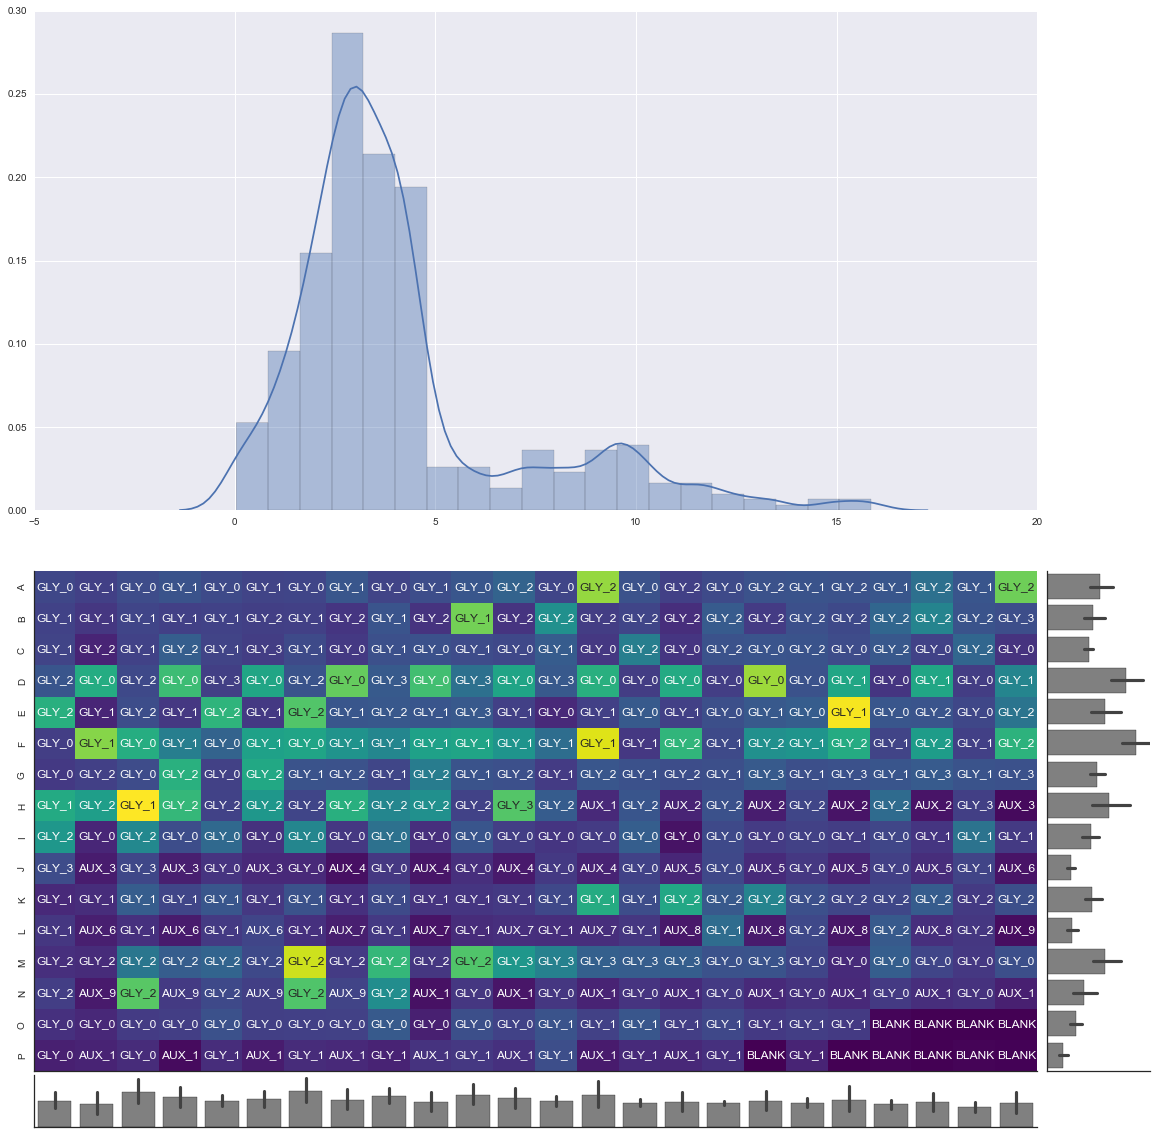

In [6]:
# get DNA concentratin information
dna_concs = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col='Well').astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col='Sample', well_col='Well')

plot_plate_vals(dna_concs,
                annot_str=names,
                color_map='viridis',
                annot_fmt='.5s')

## Step 3: calculate normalization volumes and add to plate map

This step will calculate volumes for the DNA normalization pick list.

Check the desired values for:
 - **`ng`**: the desired quantity of DNA in normed plate, in ng
 - **`total_vol`**: the total volume of normalized DNA, in nL
 - **`min_vol`**: the minimum quantity of sample to add, in nL
 - **`resolution`**: the resolution of the Echo, in nL (usually 2.5)

In [7]:
ng = 5
total_vol = 3500
min_vol = 25
resolution = 2.5

dna_vols = calculate_norm_vol(plate_df['Sample DNA Concentration'], ng=ng, min_vol=min_vol, max_vol=total_vol, resolution=resolution)
water_vols = total_vol - dna_vols

plate_df['Normalized DNA volume'] = dna_vols
plate_df['Normalized water volume'] = water_vols

plate_df.head()

,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume
0,GLY_01_012,A,1,False,A1,3.432,1457.5,2042.5
1,GLY_14_034,B,1,False,B1,3.151,1587.5,1912.5
2,GLY_11_007,C,1,False,C1,3.239,1542.5,1957.5
3,GLY_28_018,D,1,False,D1,4.212,1187.5,2312.5
4,GLY_25_003,E,1,False,E1,10.016,500.0,3000.0


## Step 4: make pick list

Format the Echo-compatible pick list.

In [8]:
norm_picklist = format_dna_norm_picklist(np.array(plate_df['Normalized DNA volume']),
                                        np.array(plate_df['Normalized water volume']),
                                        np.array(plate_df['Well']),
                                        sample_names = np.array(plate_df['Sample']),
                                        dna_concs = np.array(plate_df['Sample DNA Concentration']))

## Step 5: write pick list to file

In [9]:
# Write the picklist
norm_picklist_fp = './test_output/MRSA/2017-08-04_MRSA_1-4_DNA_norm_picklist.txt'

if os.path.isfile(norm_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [10]:
with open(norm_picklist_fp, 'w') as f:
    f.write(norm_picklist)
    
!head {norm_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Concentration	Transfer Volume	Destination Plate Name	Destination Well
GLY_01_012	Water	384PP_AQ_BP2_HT	A1	3.432	2042.5	NormalizedDNA	A1
GLY_14_034	Water	384PP_AQ_BP2_HT	B1	3.151	1912.5	NormalizedDNA	B1
GLY_11_007	Water	384PP_AQ_BP2_HT	C1	3.239	1957.5	NormalizedDNA	C1
GLY_28_018	Water	384PP_AQ_BP2_HT	D1	4.212	2312.5	NormalizedDNA	D1
GLY_25_003	Water	384PP_AQ_BP2_HT	E1	10.016	3000.0	NormalizedDNA	E1
GLY_06_106	Water	384PP_AQ_BP2_HT	F1	2.892	1770.0	NormalizedDNA	F1
GLY_07_011	Water	384PP_AQ_BP2_HT	G1	2.644	1610.0	NormalizedDNA	G1
GLY_18_043	Water	384PP_AQ_BP2_HT	H1	9.623	2980.0	NormalizedDNA	H1
GLY_28_004	Water	384PP_AQ_BP2_HT	I1	8.419	2905.0	NormalizedDNA	I1


# Workflow for assigning barcodes

This portion of the notebook will assign index values and construct an Echo picklist file for adding barcodes. 

As inputs, it requires:
1. A plate map dataframe (from previous step)
2. A tab-delimited index combination file, relating index combinations, i5 and i7 index values, and i5 and i7 index locations

The workflow then:
1. reads in the index combo list
2. assigns indices per sample
3. produces an Echo-formatted pick list file

## Step 1: Read in index combo list

This is a file that contains every possible i5 and i7 barcode combo on a separate line,
along with plate and well location information. It should look something like this:

```
index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,ACCGACAAACGTTACC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate
1,AGTGGCAACTGTGTTG,iTru5_01_B,AGTGGCAA,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate
2,CACAGACTTGAGGTGT,iTru5_01_C,CACAGACT,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate
3,CGACACTTGATCCATG,iTru5_01_D,CGACACTT,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate
4,GACTTGTGGCCTATCA,iTru5_01_E,GACTTGTG,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate
5,GTGAGACTAACAACCG,iTru5_01_F,GTGAGACT,F1,iTru5_plate,iTru7_101_06,AACAACCG,A6,iTru7_plate
6,GTTCCATGACTCGTTG,iTru5_01_G,GTTCCATG,G1,iTru5_plate,iTru7_101_07,ACTCGTTG,A7,iTru7_plate
7,TAGCTGAGCCTATGGT,iTru5_01_H,TAGCTGAG,H1,iTru5_plate,iTru7_101_08,CCTATGGT,A8,iTru7_plate
8,CTTCGCAATGTACACC,iTru5_02_A,CTTCGCAA,I1,iTru5_plate,iTru7_101_09,TGTACACC,A9,iTru7_plate
```

In [11]:
index_combo_fp = './test_output/iTru/new_iTru_combos.csv'

if not os.path.isfile(index_combo_fp):
    print("Problem! %s is not a path to a valid file" % file)

In [12]:
index_combos = pd.read_csv(index_combo_fp)
index_combos.head()

,index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,0,ACCGACAAACGTTACC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate
1,1,AGTGGCAACTGTGTTG,iTru5_01_B,AGTGGCAA,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate
2,2,CACAGACTTGAGGTGT,iTru5_01_C,CACAGACT,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate
3,3,CGACACTTGATCCATG,iTru5_01_D,CGACACTT,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate
4,4,GACTTGTGGCCTATCA,iTru5_01_E,GACTTGTG,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate


## Step 2: Assign index combo

This will pick a set of index combos from the index combo for the number of samples in the `plate_df` DataFrame.

Keep track of the barcode combinations used in the lab, and set `starting_combo` equal to the next unused combination.

One of way of doing that might be to keep track of the number of plates run, and set `starting_combo` equal to
384 * number of plates run + 1.

In [13]:
starting_combo = 0

indices = assign_index(len(plate_df['Sample']), index_combos, start_idx=starting_combo)

plate_df = pd.concat([plate_df, indices], axis=1)

plate_df.head()

,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate
0,GLY_01_012,A,1,False,A1,3.432,1457.5,2042.5,0,ACCGACAAACGTTACC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate
1,GLY_14_034,B,1,False,B1,3.151,1587.5,1912.5,1,AGTGGCAACTGTGTTG,iTru5_01_B,AGTGGCAA,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate
2,GLY_11_007,C,1,False,C1,3.239,1542.5,1957.5,2,CACAGACTTGAGGTGT,iTru5_01_C,CACAGACT,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate
3,GLY_28_018,D,1,False,D1,4.212,1187.5,2312.5,3,CGACACTTGATCCATG,iTru5_01_D,CGACACTT,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate
4,GLY_25_003,E,1,False,E1,10.016,500.0,3000.0,4,GACTTGTGGCCTATCA,iTru5_01_E,GACTTGTG,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate


## Step 3: Make index pick list

Format the Echo-compatible pick list.

In [14]:
index_picklist = format_index_picklist(plate_df['Sample'], plate_df['Well'], indices)

## Step 5: write pick list to file

In [15]:
index_picklist_fp = './test_output/MRSA/2017-08-04_MRSA_1-4_DNA_norm_picklist.txt'

if os.path.isfile(index_picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [16]:
with open(index_picklist_fp, 'w') as f:
    f.write(index_picklist)

!head {index_picklist_fp}

Sample	Source Plate Name	Source Plate Type	Source Well	Transfer Volume	Index Name	Index Sequence	Index Combo	Destination Plate Name	Destination Well
GLY_01_012	iTru5_plate	384LDV_AQ_B2_HT	A1	250	iTru5_01_A	ACCGACAA	0	IndexPCRPlate	A1
GLY_14_034	iTru5_plate	384LDV_AQ_B2_HT	B1	250	iTru5_01_B	AGTGGCAA	1	IndexPCRPlate	B1
GLY_11_007	iTru5_plate	384LDV_AQ_B2_HT	C1	250	iTru5_01_C	CACAGACT	2	IndexPCRPlate	C1
GLY_28_018	iTru5_plate	384LDV_AQ_B2_HT	D1	250	iTru5_01_D	CGACACTT	3	IndexPCRPlate	D1
GLY_25_003	iTru5_plate	384LDV_AQ_B2_HT	E1	250	iTru5_01_E	GACTTGTG	4	IndexPCRPlate	E1
GLY_06_106	iTru5_plate	384LDV_AQ_B2_HT	F1	250	iTru5_01_F	GTGAGACT	5	IndexPCRPlate	F1
GLY_07_011	iTru5_plate	384LDV_AQ_B2_HT	G1	250	iTru5_01_G	GTTCCATG	6	IndexPCRPlate	G1
GLY_18_043	iTru5_plate	384LDV_AQ_B2_HT	H1	250	iTru5_01_H	TAGCTGAG	7	IndexPCRPlate	H1
GLY_28_004	iTru5_plate	384LDV_AQ_B2_HT	I1	250	iTru5_02_A	CTTCGCAA	8	IndexPCRPlate	I1


# Workflow for calculating pooling

This portion of the notebook calculates pooling based on qPCR values, and produces visual outputs to interpret and check values. 

As inputs, this workflow requires:
1. A plate map DataFrame (from previous step)
2. qPCR output (tab-delimited text format with columns 'Cp' and 'Pos')

The workflow:
1. reads in qPCR output and calculates estimated library concentration
4. calculates pooling values and generates an Echo pick list

## Step 1: read in input files

**Enter the correct path to the qPCR output file**.

In [17]:
qpcr_input_fp = './test_data/MRSA/Quant/qPCR/2017-08-04_MRSA_1-4.txt'

for file in [qpcr_input_fp]:
    if not os.path.isfile(file):
        print("Problem! %s is not a path to a valid file" % file)

### Read in qPCR output. 

This file should look something like this:

```
Experiment: 2017-05-19_Knight_CF+ABTX+AGP_KHP_rerun  Selected Filter: SYBR Green I / HRM Dye (465-510)
Include	Color	Pos	Name	Cp	Concentration	Standard	Status
True	255	A1	Sample 1	20.55		0	
True	255	A2	Sample 2	  9.15		0	
True	255	A3	Sample 3	  9.16		0	
True	255	A4	Sample 4	  8.89		0	
True	255	A5	Sample 5	  8.43		0	
True	255	A6	Sample 6	  8.66		0	
True	255	A7	Sample 7	  8.84		0	
True	255	A8	Sample 8	  8.85		0
```

In [18]:
qpcr_df = pd.read_csv(qpcr_input_fp, sep = '\t', skiprows=1, header=0)
qpcr_df.head()

,Include,Color,Pos,Name,Cp,Concentration,Standard,Status
0,True,255,A1,Sample 1,14.20,NaN,0,NaN
1,True,255,A2,Sample 2,16.19,NaN,0,NaN
2,True,255,A3,Sample 3,15.87,NaN,0,NaN
3,True,255,A4,Sample 4,17.75,NaN,0,NaN
4,True,255,A5,Sample 5,15.42,NaN,0,NaN


## Step 2: add to data frame

In [19]:
plate_df = pd.merge(plate_df, qpcr_df[['Pos','Cp']], left_on='Well', right_on='Pos')

plate_df.head()

,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,index combo,index combo seq,i5 name,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp
0,GLY_01_012,A,1,False,A1,3.432,1457.5,2042.5,0,ACCGACAAACGTTACC,iTru5_01_A,ACCGACAA,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate,A1,14.20
1,GLY_14_034,B,1,False,B1,3.151,1587.5,1912.5,1,AGTGGCAACTGTGTTG,iTru5_01_B,AGTGGCAA,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate,B1,13.24
2,GLY_11_007,C,1,False,C1,3.239,1542.5,1957.5,2,CACAGACTTGAGGTGT,iTru5_01_C,CACAGACT,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate,C1,14.44
3,GLY_28_018,D,1,False,D1,4.212,1187.5,2312.5,3,CGACACTTGATCCATG,iTru5_01_D,CGACACTT,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate,D1,13.54
4,GLY_25_003,E,1,False,E1,10.016,500.0,3000.0,4,GACTTGTGGCCTATCA,iTru5_01_E,GACTTGTG,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate,E1,13.86


## Step 3: calculate sample concentration

This step will calculate the estimated concentration based on Cp value. It will also add this info back to the sample data frame.

In [20]:
plate_df['Library Concentration'] = compute_qpcr_concentration(plate_df['Cp'])

plate_df.head()

,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,index combo,index combo seq,...,i5 sequence,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp,Library Concentration
0,GLY_01_012,A,1,False,A1,3.432,1457.5,2042.5,0,ACCGACAAACGTTACC,...,ACCGACAA,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate,A1,14.20,5.436218
1,GLY_14_034,B,1,False,B1,3.151,1587.5,1912.5,1,AGTGGCAACTGTGTTG,...,AGTGGCAA,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate,B1,13.24,10.775030
2,GLY_11_007,C,1,False,C1,3.239,1542.5,1957.5,2,CACAGACTTGAGGTGT,...,CACAGACT,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate,C1,14.44,4.581592
3,GLY_28_018,D,1,False,D1,4.212,1187.5,2312.5,3,CGACACTTGATCCATG,...,CGACACTT,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate,D1,13.54,8.700976
4,GLY_25_003,E,1,False,E1,10.016,500.0,3000.0,4,GACTTGTGGCCTATCA,...,GACTTGTG,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate,E1,13.86,6.926717


## Step 4: calculate pooling values

This step will calculate the sample pooling, and update the sample data frame with the pool info.

You can change some variables if you want different behavior:

- **min_conc**: This is the minimum concentration for a sample to be considered for pooling. Set to 0 to pool all samples, regardless of concentration. Increasing this will have the effect of increasing pool concentration, at the expense of samples dropping out. 
- **floor_conc**: This is the lowest concentration equivalent for which a sample will be accurately pooled. Samples below this concentration will be pooled to the volume that they would have been if they were actually that concentration. For example, if `floor_conc=20`, and a sample at 20 nM pools at 500 nL, a sample at 40 nM will pool at 250 nL but a sample at 10 nM will still pool at 500 nL (rather than 1000). Increasing this value will have the effect of increasing pool concentration, but decreasing read counts for low-concentration samples. 
- **total_nmol**: This is the total number of molecules to shoot for in the pool. Increasing this will increase the overall volume of the pool. 

In [21]:
plate_df['Pooled Volume'] = compute_shotgun_pooling_values_qpcr(np.nan_to_num(plate_df['Library Concentration']),
                                        min_conc=0, floor_conc=40,
                                        total_nmol=.008)
plate_df.head()

,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,index combo,index combo seq,...,i5 well,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp,Library Concentration,Pooled Volume
0,GLY_01_012,A,1,False,A1,3.432,1457.5,2042.5,0,ACCGACAAACGTTACC,...,A1,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate,A1,14.20,5.436218,520.833333
1,GLY_14_034,B,1,False,B1,3.151,1587.5,1912.5,1,AGTGGCAACTGTGTTG,...,B1,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate,B1,13.24,10.775030,520.833333
2,GLY_11_007,C,1,False,C1,3.239,1542.5,1957.5,2,CACAGACTTGAGGTGT,...,C1,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate,C1,14.44,4.581592,520.833333
3,GLY_28_018,D,1,False,D1,4.212,1187.5,2312.5,3,CGACACTTGATCCATG,...,D1,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate,D1,13.54,8.700976,520.833333
4,GLY_25_003,E,1,False,E1,10.016,500.0,3000.0,4,GACTTGTGGCCTATCA,...,E1,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate,E1,13.86,6.926717,520.833333


The estimated pool volume and concentration are (concentration, nM; volume, nL):

In [22]:
estimate_pool_conc_vol(plate_df['Pooled Volume'], plate_df['Library Concentration'])

(61.085766495836083, 97703.060738032887)

## Step 5: visualization

This step will present visuals of the results, including:
1. Scatter plot of DNA concentrations by Library concentration
2. Plate-wise heatmap and histogram showing library concentrations
3. per-96-well plate heatmaps and histograms showing library concentrations and sample names
4. Plate-wise heatmap showing pooling values

### Library concentration by sample DNA concentration:

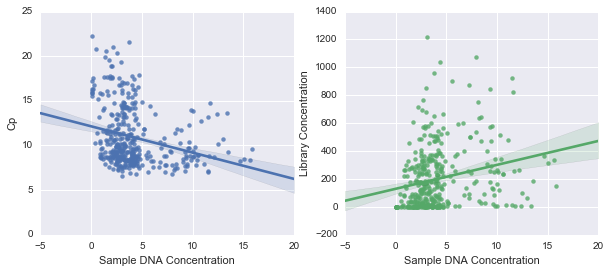

In [23]:
f, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

sns.regplot(x="Sample DNA Concentration", y="Cp", data=plate_df, ax = ax1);
sns.regplot(x="Sample DNA Concentration", y="Library Concentration", data=plate_df, ax = ax2);

### Library concentration heatmap, whole plate

In [24]:
# get concentration and pooling values for plotting
concs = make_2D_array(plate_df, data_col="Library Concentration", well_col='Well').astype(float)
vols = make_2D_array(plate_df, data_col='Pooled Volume', well_col='Well').astype(float)
dna = make_2D_array(plate_df, data_col='Sample DNA Concentration', well_col='Well').astype(float)

# get information for annotation
names = make_2D_array(plate_df, data_col='Sample', well_col='Well')
i5 = make_2D_array(plate_df, data_col='i5 name', well_col='Well')
i7 = make_2D_array(plate_df, data_col='i7 name', well_col='Well')

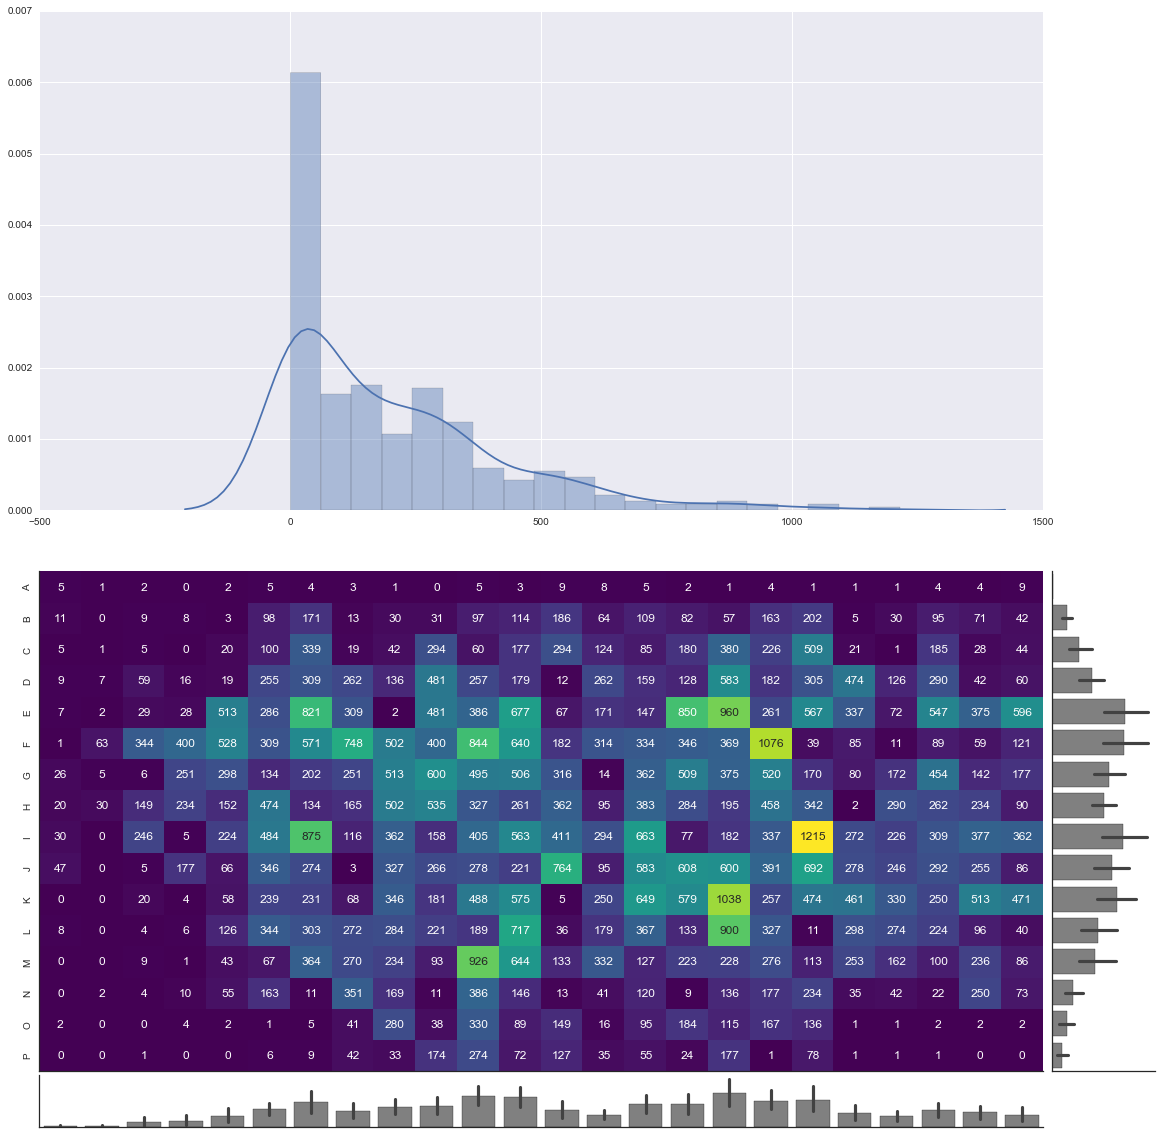

In [25]:
plot_plate_vals(concs, color_map='viridis')

### Plate maps for individual constituent plates

In [26]:
# Make mask arrays for even and odd rows and columns

even_rows = [x for x in range(16) if x % 2 == 0]
odd_rows = [x for x in range(16) if x % 2 == 1]
even_cols = [x for x in range(24) if x % 2 == 0]
odd_cols = [x for x in range(24) if x % 2 == 1]

### Library concentration heatmap, Plate 1

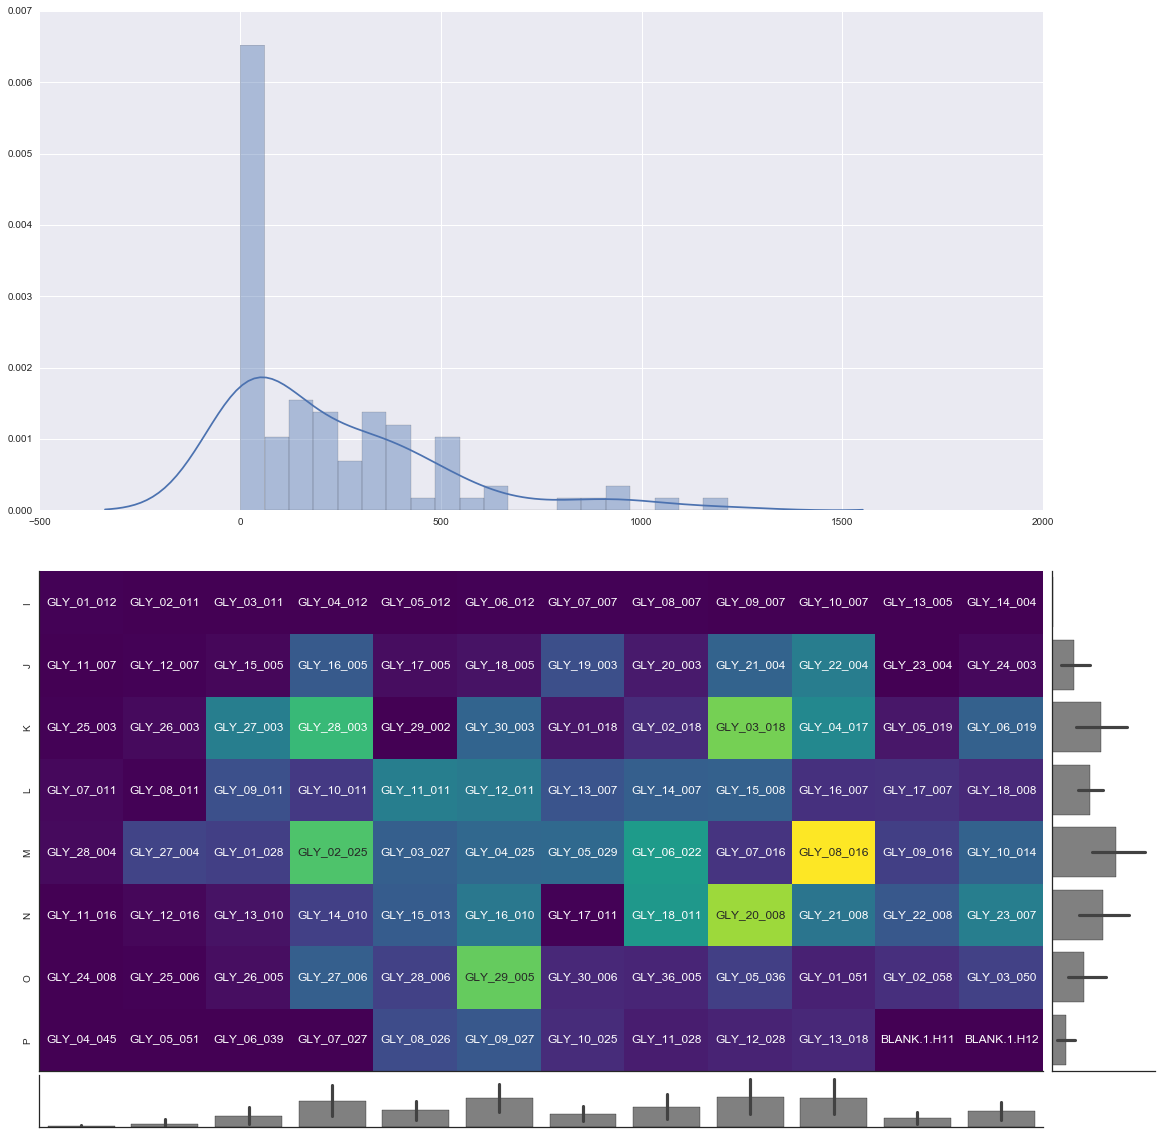

In [27]:
plot_plate_vals(concs[np.ix_(even_rows,even_cols)],
                annot_str= names[np.ix_(even_rows,even_cols)],
                color_map='viridis',
                annot_fmt='')

### Library concentration heatmap, Plate 2

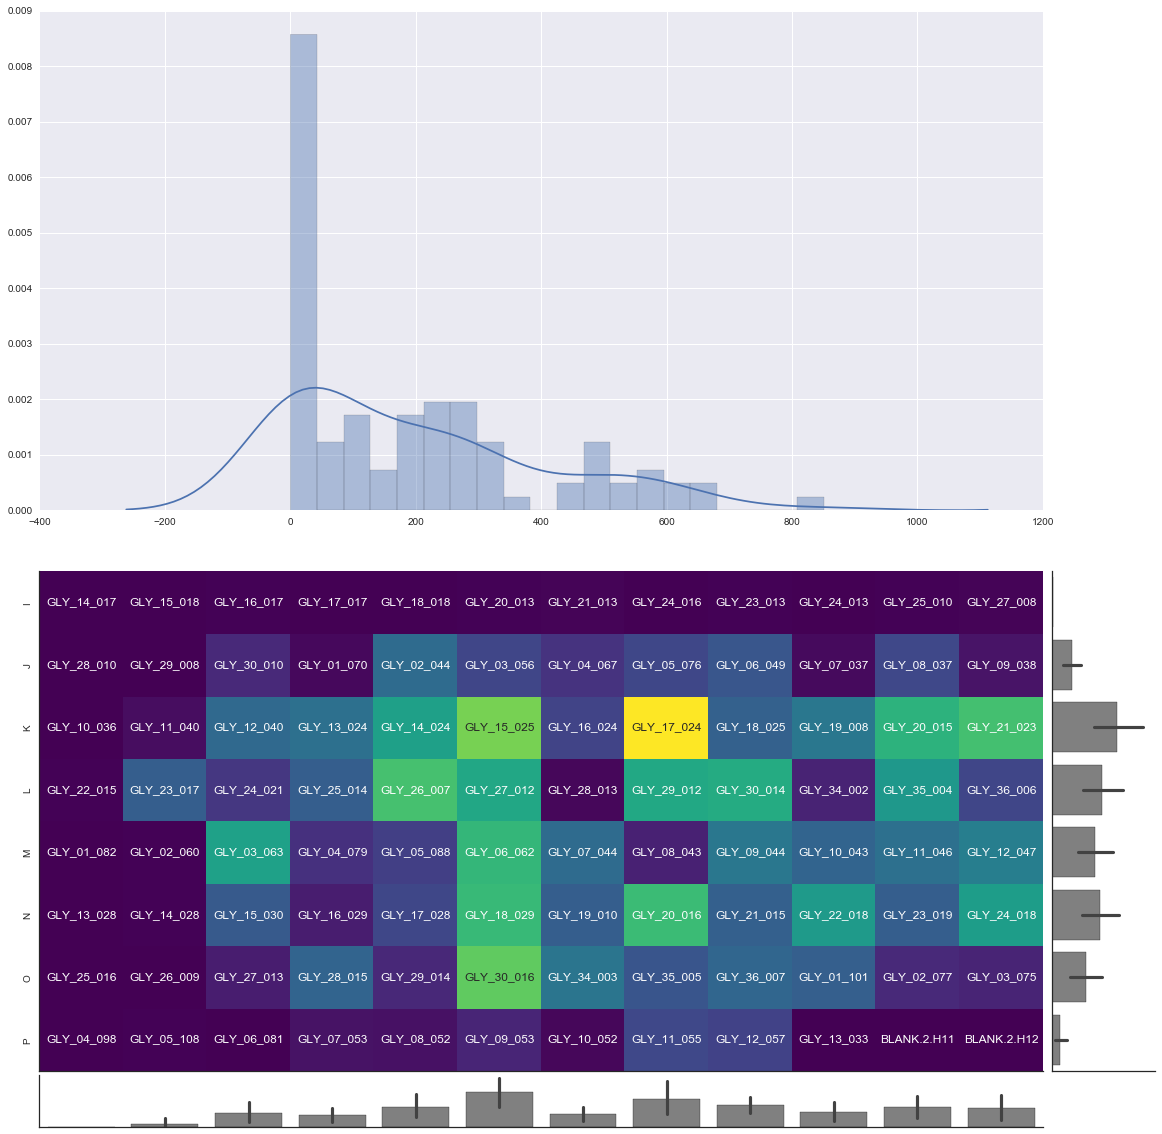

In [28]:
plot_plate_vals(concs[np.ix_(even_rows,odd_cols)],
                annot_str=names[np.ix_(even_rows,odd_cols)],
                color_map='viridis',
                annot_fmt='')

### Library concentration heatmap, Plate 3

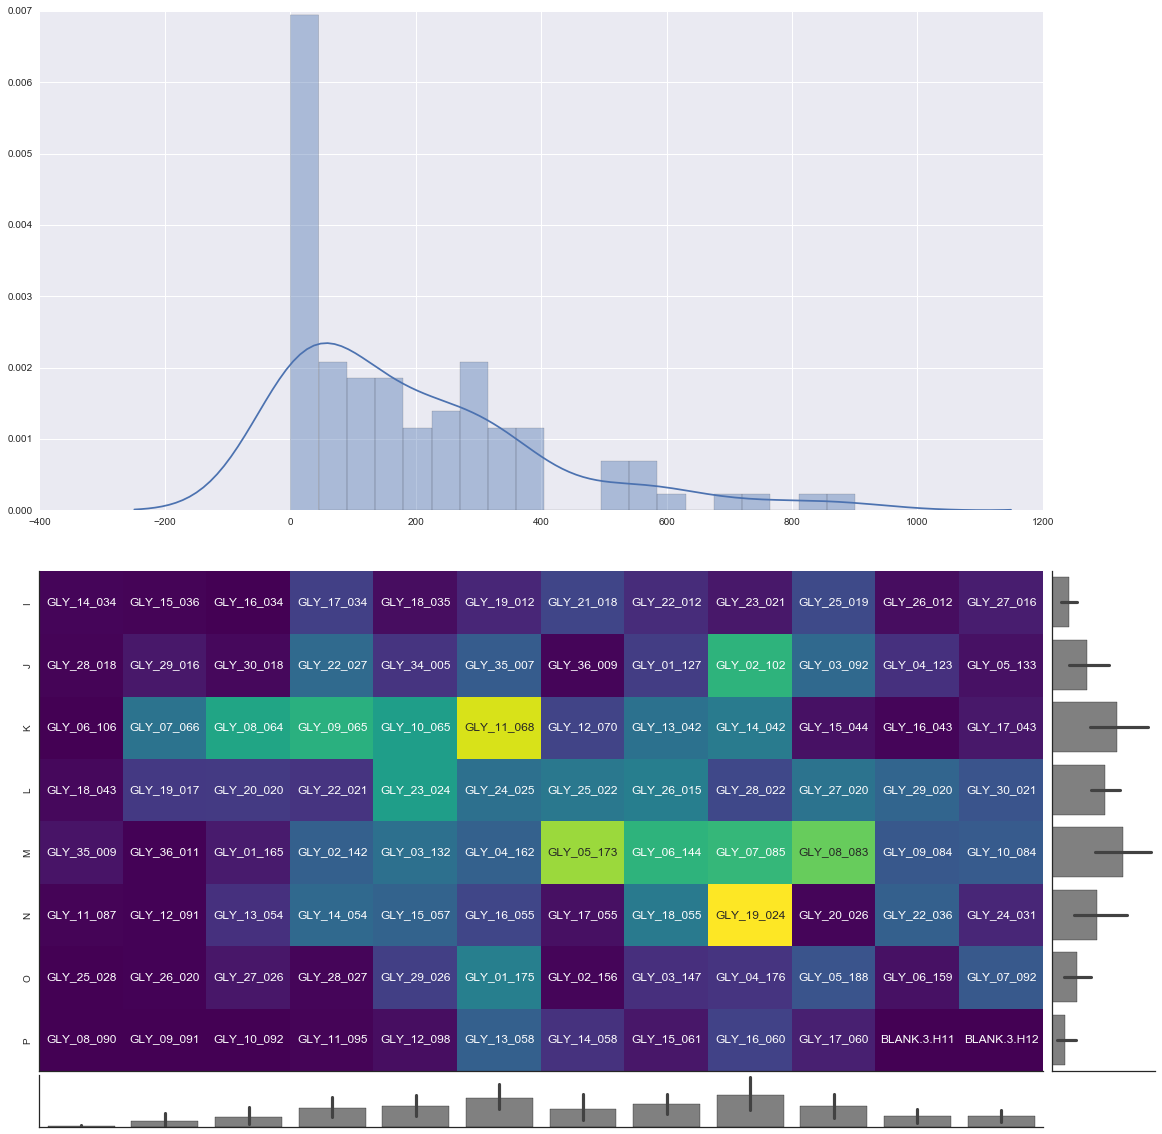

In [29]:
plot_plate_vals(concs[np.ix_(odd_rows, even_cols)],
                annot_str=names[np.ix_(odd_rows, even_cols)],
                color_map='viridis',
                annot_fmt='')

### Library concentration heatmap, Plate 4

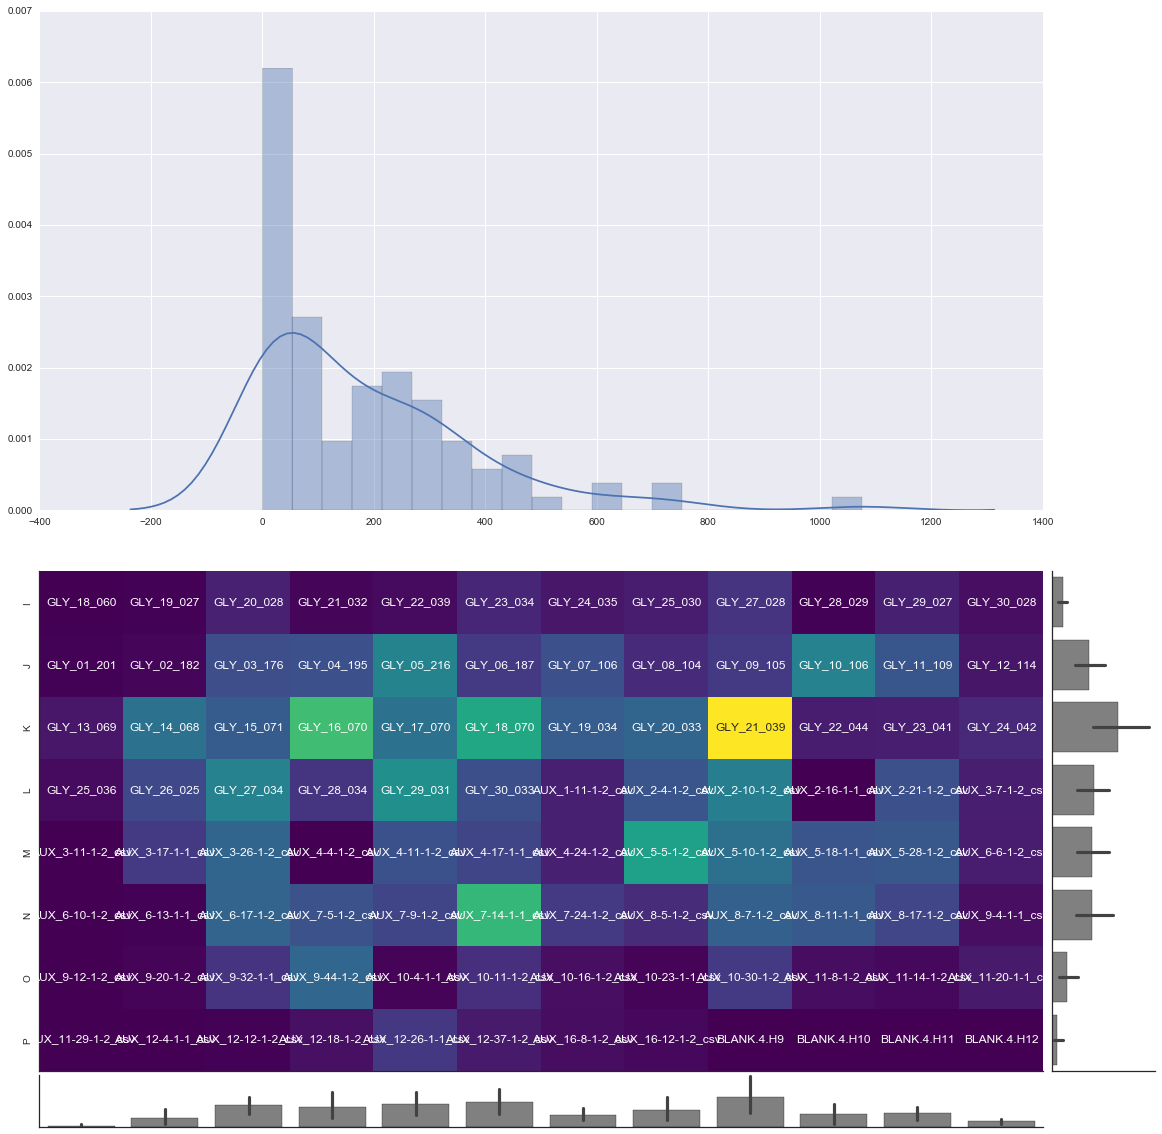

In [30]:
plot_plate_vals(concs[np.ix_(odd_rows, odd_cols)],
                annot_str=names[np.ix_(odd_rows, odd_cols)],
                color_map='viridis',
                annot_fmt='')

### Plot pooling volumes

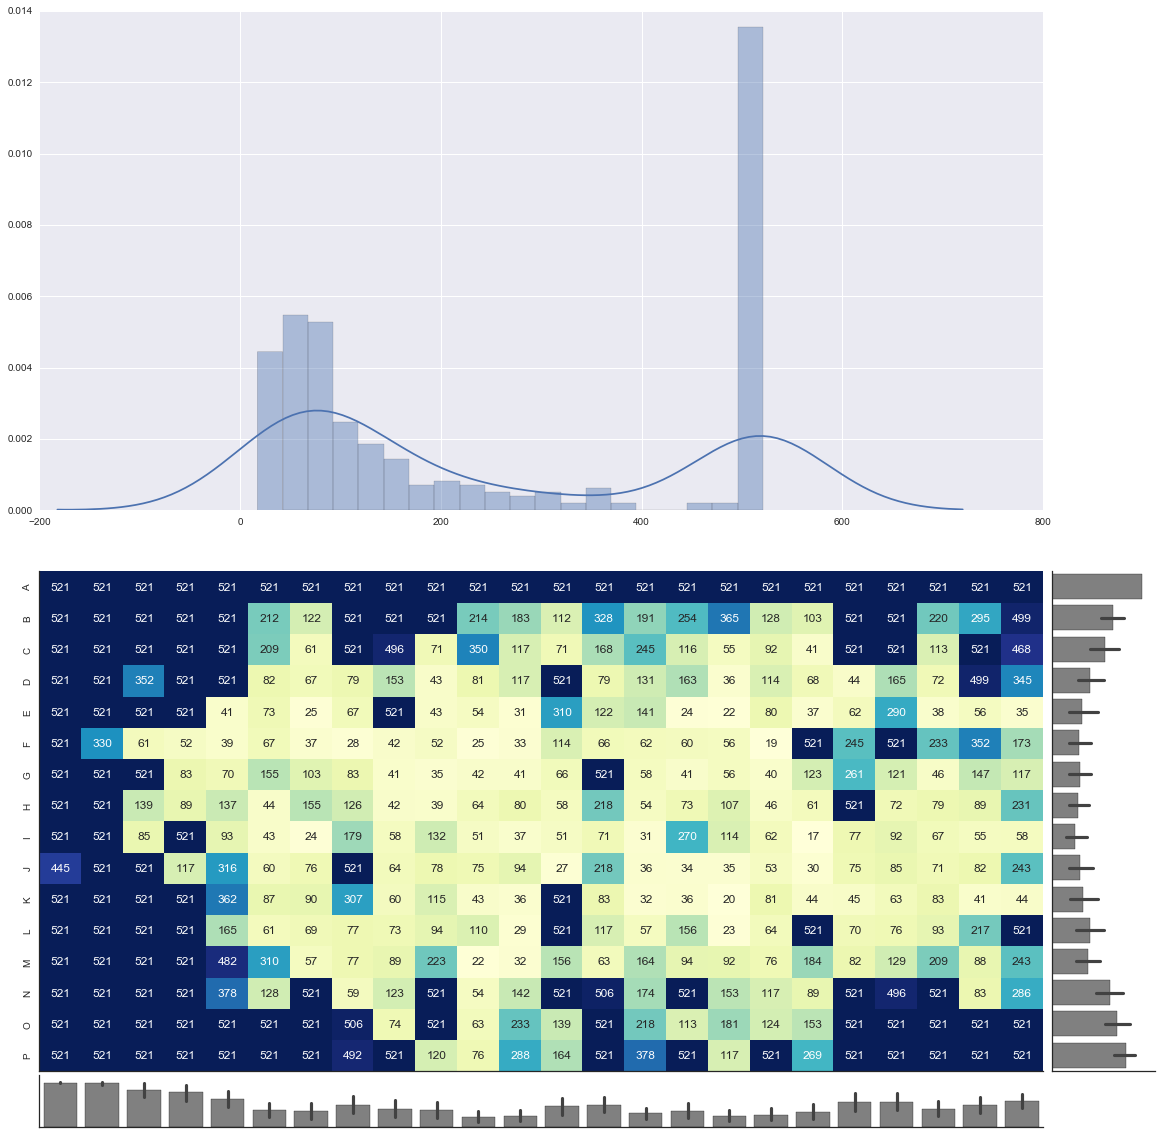

In [31]:
plot_plate_vals(vols)

## Step 6: write pooling pick list

In [32]:
# Write the picklist
picklist_fp = './test_output/MRSA/2017-08-04_MRSA_1-4_qPCR_pooling_picklist.txt'

if os.path.isfile(picklist_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [33]:
picklist = format_pooling_echo_pick_list(vols, max_vol_per_well=30000)
with open(picklist_fp,'w') as f:
    f.write(picklist)

!head {picklist_fp}

Source Plate Name,Source Plate Type,Source Well,Concentration,Transfer Volume,Destination Plate Name,Destination Well
1,384LDV_AQ_B2_HT,A1,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A2,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A3,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A4,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A5,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A6,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A7,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A8,,520.83,NormalizedDNA,A1
1,384LDV_AQ_B2_HT,A9,,520.83,NormalizedDNA,A1


# Make HiSeq sample sheet

This workflow takes the pooled sample information and writes an Illumina sample sheet that can be given directly to the sequencing center. 

As inputs, this notebook requires:
1. A plate map DataFrame (from previous step)

The workflow:
1. formats sample names as bcl2fastq-compatible
2. formats sample data
3. sets values for sample sheet fields and formats sample sheet.
4. writes the sample sheet to a file

## Step 1: Format sample names to be bcl2fastq-compatible

bcl2fastq requires *only* alphanumeric, hyphens, and underscore characters. We'll replace all non-those characters
with underscores and add the bcl2fastq-compatible names to the DataFrame.

In [34]:
plate_df['sample sheet Sample_ID'] = plate_df['Sample'].map(bcl_scrub_name)

plate_df.head()

,Sample,Row,Col,Blank,Well,Sample DNA Concentration,Normalized DNA volume,Normalized water volume,index combo,index combo seq,...,i5 plate,i7 name,i7 sequence,i7 well,i7 plate,Pos,Cp,Library Concentration,Pooled Volume,sample sheet Sample_ID
0,GLY_01_012,A,1,False,A1,3.432,1457.5,2042.5,0,ACCGACAAACGTTACC,...,iTru5_plate,iTru7_101_01,ACGTTACC,A1,iTru7_plate,A1,14.20,5.436218,520.833333,GLY_01_012
1,GLY_14_034,B,1,False,B1,3.151,1587.5,1912.5,1,AGTGGCAACTGTGTTG,...,iTru5_plate,iTru7_101_02,CTGTGTTG,A2,iTru7_plate,B1,13.24,10.775030,520.833333,GLY_14_034
2,GLY_11_007,C,1,False,C1,3.239,1542.5,1957.5,2,CACAGACTTGAGGTGT,...,iTru5_plate,iTru7_101_03,TGAGGTGT,A3,iTru7_plate,C1,14.44,4.581592,520.833333,GLY_11_007
3,GLY_28_018,D,1,False,D1,4.212,1187.5,2312.5,3,CGACACTTGATCCATG,...,iTru5_plate,iTru7_101_04,GATCCATG,A4,iTru7_plate,D1,13.54,8.700976,520.833333,GLY_28_018
4,GLY_25_003,E,1,False,E1,10.016,500.0,3000.0,4,GACTTGTGGCCTATCA,...,iTru5_plate,iTru7_101_05,GCCTATCA,A5,iTru7_plate,E1,13.86,6.926717,520.833333,GLY_25_003


# Step 2: format sample sheet data

This step formats the data columns appropriately for the sample sheet, using the values we've calculated previously.

The newly-created bcl2fastq-compatible names will be in the **`Sample ID`** and **`Sample Name`** columns. The
original sample names will be in the **`Description`** column.

Modify **`lanes`** to indicate which lanes this pool will be sequenced on.

**`project_name`** and **`project_plate`** values will be placed in the **`Sample Project`** and **`Sample Name`**
columns, respectively.

In [35]:
lanes = [1,2,3,4]
project_name = 'Example Project'
project_plate = 'Example Plate 1'

data = format_sample_data(plate_df['sample sheet Sample_ID'],
                          plate_df['i7 name'], plate_df['i7 sequence'],
                          plate_df['i5 name'], plate_df['i5 sequence'],
                          wells=plate_df['Well'],
                          sample_plate=project_plate,
                          description=plate_df['Sample'],
                          sample_proj=project_name,
                          lanes=lanes, sep='\t')

## Step 3: add comments and set sample sheet values

Comment lines can be added in the **`comments`** variable. These will be prepended with `#` and placed at the top of the file. 

Other fields in the sample sheet can be changed in the **`sample_sheet_dict`**.

In [36]:
comments = 'PI\tKnight\trobknight@ucsd.edu\t\t\n' + \
'Contact\tJeff Dereus\tGail Ackermann\tJon Sanders\tGreg Humphrey\n' + \
'\tjdereus@ucsd.edu\tackermag@ucsd.edu\tjonsan@gmail.com\tghsmu414@gmail.com\n'

sample_sheet_dict = {'comments': comments,
          'IEMFileVersion': '4',
          'Investigator Name': 'Knight',
          'Experiment Name': '',
          'Date': '2017-08-13',
          'Workflow': 'GenerateFASTQ',
          'Application': 'FASTQ Only',
          'Assay': 'Metagenomics',
          'Description': '',
          'Chemistry': 'Default',
          'read1': 150,
          'read2': 150,
          'ReverseComplement': '0',
          'data': data}

# format sample sheet
sample_sheet = format_sample_sheet(sample_sheet_dict)

## Step 4: Write the sample sheet to file

In [37]:
sample_sheet_fp = './test_output/MRSA/2017-08-04_MRSA_1-4_sample_sheet.txt'

if os.path.isfile(sample_sheet_fp):
    print("Warning! This file exists already.")

Warning! This file exists already.


In [38]:
with open(sample_sheet_fp,'w') as f:
    f.write(sample_sheet)
    
!head -n 30 {sample_sheet_fp}

# PI	Knight	robknight@ucsd.edu		
# Contact	Jeff Dereus	Gail Ackermann	Jon Sanders	Greg Humphrey
# 	jdereus@ucsd.edu	ackermag@ucsd.edu	jonsan@gmail.com	ghsmu414@gmail.com
[Header]
IEMFileVersion	4
Investigator Name	Knight
Experiment Name	
Date	2017-08-13
Workflow	GenerateFASTQ
Application	FASTQ Only
Assay	Metagenomics
Description	
Chemistry	Default

[Reads]
150
150

[Settings]
ReverseComplement	0

[Data]
Lane	Sample_ID	Sample_Name	Sample_Plate	Sample_Well	I7_Index_ID	index	I5_Index_ID	index2	Sample_Project	Description
1	GLY_01_012	GLY_01_012	Example Plate 1	A1	iTru7_101_01	ACGTTACC	iTru5_01_A	ACCGACAA	Example Project	GLY_01_012
1	GLY_14_034	GLY_14_034	Example Plate 1	B1	iTru7_101_02	CTGTGTTG	iTru5_01_B	AGTGGCAA	Example Project	GLY_14_034
1	GLY_11_007	GLY_11_007	Example Plate 1	C1	iTru7_101_03	TGAGGTGT	iTru5_01_C	CACAGACT	Example Project	GLY_11_007
1	GLY_28_018	GLY_28_018	Example Plate 1	D1	iTru7_101_04	GATCCATG	iTru5_01_D	CGACACTT	Example Project	GLY_28_018
1	GLY_25_003	GLY_25_003	Examp